In [1]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
import numpy.random as random
import scipy as sp
from scipy import stats
from scipy import integrate
from pandas import Series, DataFrame
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import math
from random import Random

from GLMM_model import PoissonRegression_Non_Bayes
from GLMM_model import poisson_distribution, normal_distribution


In [2]:
def agg_data_for_unit():
    data_sets = pd.DataFrame()
    beacon_files = os.listdir('raw_data/')
    pos_files = os.listdir('POS_RAW_data/')

    beacon_files.sort()
    pos_files.sort()
    
    if beacon_files[0] == ".DS_Store":
        beacon_files.pop(0)

    if pos_files[0] == ".DS_Store":
        pos_files.pop(0)

    pos_files = list(map(lambda x: x[:14], pos_files))[::2]

    for beacon_file, pos_file in zip(beacon_files, pos_files):
        date_beacon = beacon_file[9:17]
        date_pos    = pos_file[6:14]

        if date_beacon != date_pos:
            continue
        else:
            date = date_beacon
        
        t_start = datetime.strptime(f'{date} 09:00', '%Y%m%d %H:%M').timestamp()
        t_end   = datetime.strptime(f'{date} 21:00', '%Y%m%d %H:%M').timestamp()
        rssi    = 70
        beacon_data = pd.read_csv(f"raw_data/{beacon_file}")
        pos_data1 = pd.read_csv(f"POS_RAW_data/{pos_file}_01.csv")
        pos_data2 = pd.read_csv(f"POS_RAW_data/{pos_file}_02.csv")

        pos_data1 = pos_data1[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
        pos_data2 = pos_data2[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
        pos_data  = pd.concat([pos_data1, pos_data2])

        pos_data[["単価", "数量", "合計金額"]] = pos_data[["単価", "数量", "合計金額"]].map(lambda x: int(x))
        pos_data = pos_data.groupby(["商品コード", "商品名称（または券名称）"]).sum()

        pos_data["単価"] = pos_data["合計金額"] / pos_data["数量"]
        pos_data["単価"] = pos_data["単価"].astype(int)

        beacon_data.columns = ["No.", "mac-address", "distance", "rssi", "random", "timestamp"]
        beacon_data = beacon_data[beacon_data["random"] == 1]
        beacon_data = beacon_data[beacon_data["timestamp"] >= t_start]
        beacon_data = beacon_data[beacon_data["timestamp"] <= t_end]
        beacon_data = beacon_data[beacon_data["rssi"] < rssi]
        beacon_data = beacon_data.drop_duplicates("mac-address")

        per_unit = pd.DataFrame(
            {
                "date":[date],
                "総ビーコン数": [len(beacon_data)],
                "総売上点数": [pos_data["数量"].sum()],
                "総売上": [pos_data["合計金額"].sum()],
            }
        )
        data_sets = pd.concat([data_sets, per_unit])

    return data_sets.reset_index(drop=True)

In [3]:
def calc_variance(real_y, mean_y):
    tmp_y = (real_y - mean_y) ** 2
    tmp_y = tmp_y.sum() / len(tmp_y)
    return tmp_y

def calc_standard_deviation(real_y, mean_y):
    tmp_y = calc_variance(real_y, mean_y)
    tmp_y = np.sqrt(tmp_y)
    return tmp_y

切片： 6.72060687485082
傾き： [0.15105001]
標準偏差σ:23.623
3σ:70.869


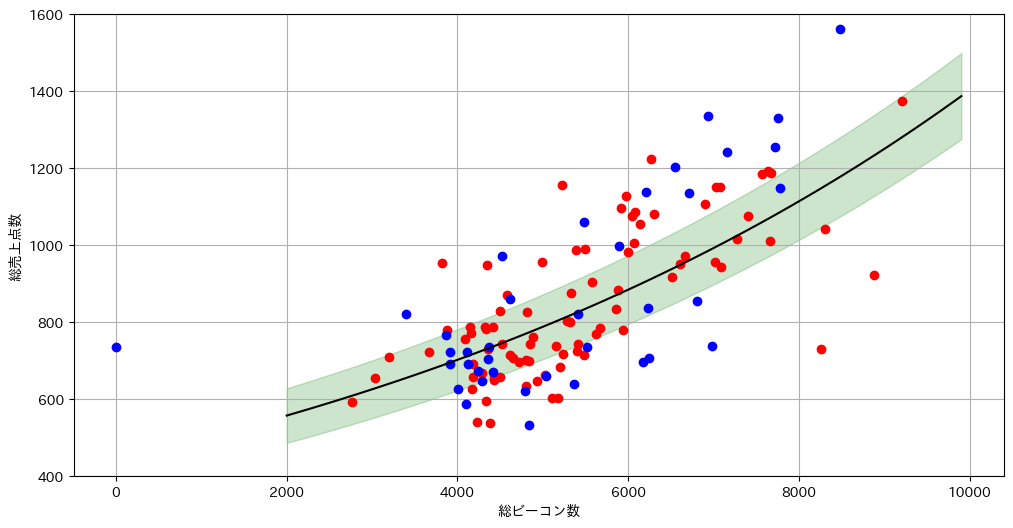

In [4]:
data_sets = agg_data_for_unit()

X = data_sets.drop(["date", "総売上点数", "総売上"], axis=1)
y = data_sets["総売上点数"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = PoissonRegression_Non_Bayes(isGLMM=False)
model.fit(X_train, y_train)

x = np.arange(2000, 10000, 100)
x = x.reshape(len(x), 1)

mean = model.predict(x)
var  = np.sqrt(mean)

print("切片：", model.alpha0)
print("傾き：", model.alpha)
print("標準偏差σ:{:.3f}".format(var[0]))
print("3σ:{:.3f}".format(3*var[0]))

plt.figure(figsize=(12, 6))

plt.plot(X_train, y_train, "o", color="red")
plt.plot(X_test,  y_test,  "o", color="blue")
plt.plot(x,       mean,    "-", color="black")
plt.fill_between(x.reshape(len(x)), mean - 3*var, mean + 3*var, color="green", alpha=0.2)
plt.xlabel("総ビーコン数")
plt.ylabel("総売上点数")
plt.ylim(400, 1600)
plt.grid(True)

総サンプル数： 37250
理論上の標準偏差： 27.285857644042864
実際の標準偏差: 101.87408349962658


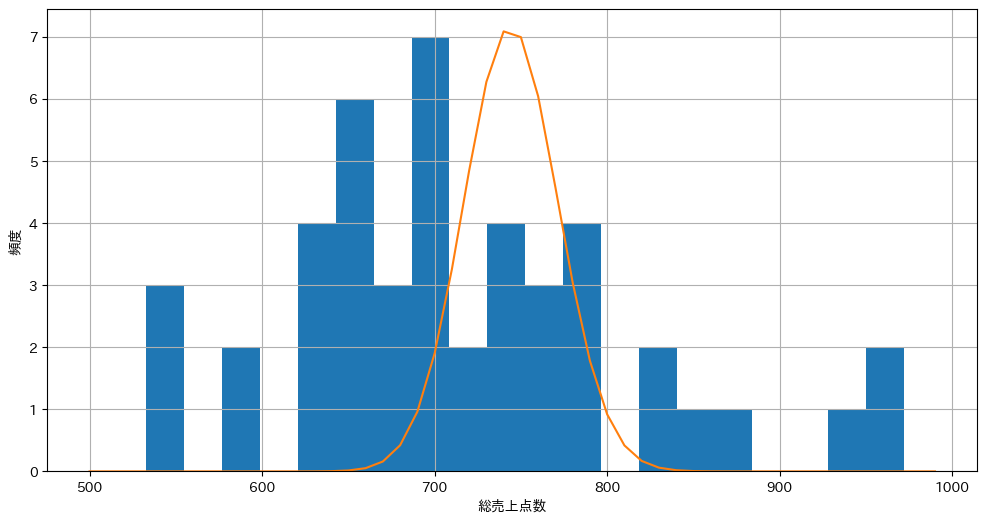

In [5]:
datasets_tmp = data_sets[(4000 < data_sets["総ビーコン数"]) & (data_sets["総ビーコン数"] < 5000)]
mean = model.predict([[4500],])[0]
y = datasets_tmp["総売上点数"]

x = np.arange(500, 1000, 10)
x = x.reshape(len(x))
poisson_y = list(map(lambda x_: poisson_distribution(x_, mean) * (np.max(x) - np.min(x)), x))

plt.figure(figsize=(12, 6))

plt.hist(y, bins=20)
plt.plot(x, poisson_y, "-")
plt.xlabel("総売上点数")
plt.ylabel("頻度")
plt.grid(True)

print("総サンプル数：", np.sum(x))
print("理論上の標準偏差：", np.sqrt(mean))
print("実際の標準偏差:", calc_standard_deviation(y, y.mean()))

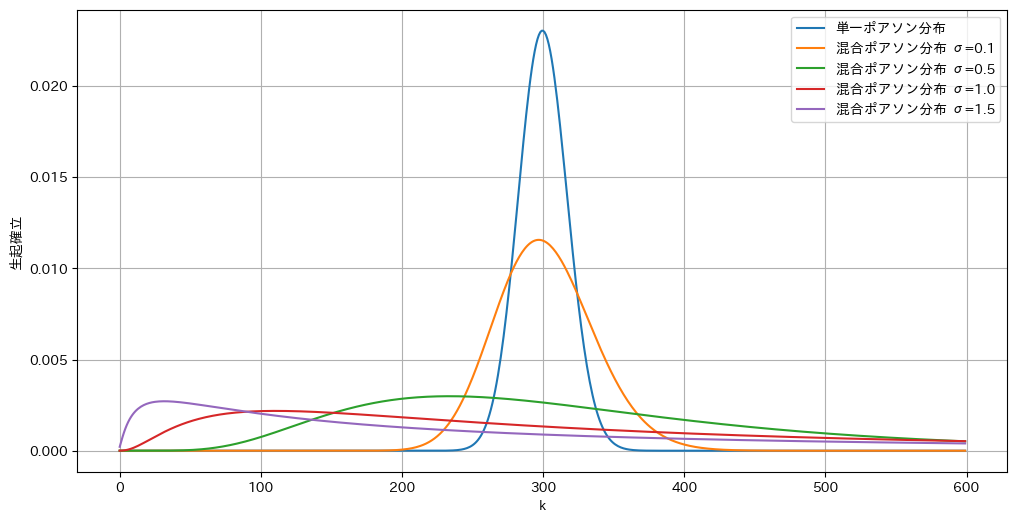

In [6]:
def calc_norm(r, sigma):
    tmp = normal_distribution(r, 0, sigma)
    return tmp

def calc_L(k, lambda_, sigma):
    def calc_poisson(k, lambda_):
        return stats.poisson.pmf(k, lambda_)
    
    range_σ = max(10*sigma, 1)
    tmp = integrate.quad(lambda r: calc_poisson(k, lambda_ * np.exp(r)) * calc_norm(r, sigma), -range_σ, range_σ)[0]
    return tmp

pre_lambda = 300
start, end = 0, 2*pre_lambda
x = np.arange(start, end, 1)
x = x.reshape(len(x), 1)

y1 = stats.poisson.pmf(x, pre_lambda)
y2 = np.frompyfunc(calc_L, 3, 1)(x, pre_lambda, 0.1)
y3 = np.frompyfunc(calc_L, 3, 1)(x, pre_lambda, 0.5)
y4 = np.frompyfunc(calc_L, 3, 1)(x, pre_lambda, 1.0)
y5 = np.frompyfunc(calc_L, 3, 1)(x, pre_lambda, 1.5)


plt.figure(figsize=(12, 6))

plt.plot(x, y1, "-", label="単一ポアソン分布")
plt.plot(x, y2, "-", label="混合ポアソン分布 σ=0.1")
plt.plot(x, y3, "-", label="混合ポアソン分布 σ=0.5")
plt.plot(x, y4, "-", label="混合ポアソン分布 σ=1.0")
plt.plot(x, y5, "-", label="混合ポアソン分布 σ=1.5")
plt.xlabel("k")
plt.ylabel("生起確立")
plt.grid(True)
plt.legend()

総サンプル数： 37250
理論上の標準偏差： 27.285857644042864
実際の標準偏差: 101.87408349962658


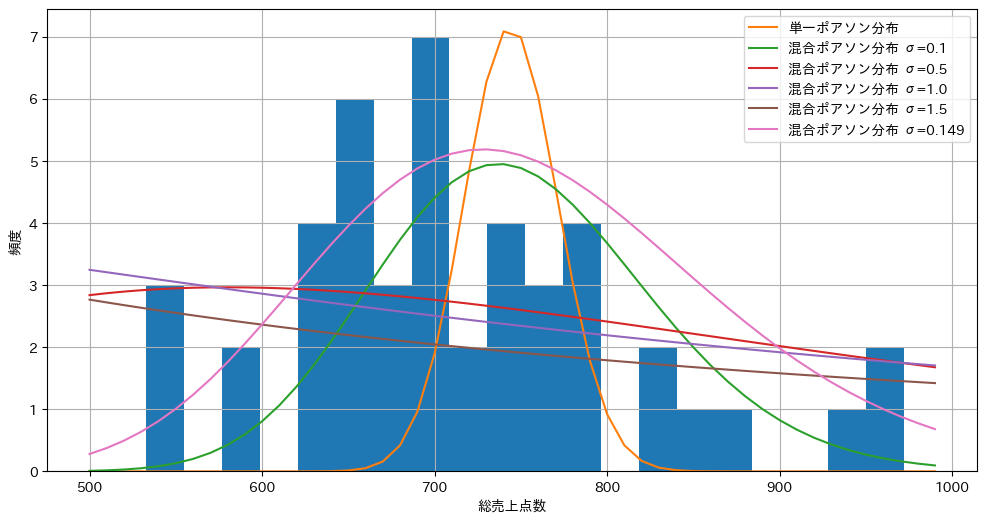

In [7]:
datasets_tmp = data_sets[(4000 < data_sets["総ビーコン数"]) & (data_sets["総ビーコン数"] < 5000)]
mean = model.predict([[4500],])[0]
y = datasets_tmp["総売上点数"]

x = np.arange(500, 1000, 10)
x = x.reshape(len(x))

y1 = stats.poisson.pmf(x, mean)                * (np.max(x) - np.min(x))
y2 = np.frompyfunc(calc_L, 3, 1)(x, mean, 0.1) * (np.max(x) - np.min(x)) * 2
y3 = np.frompyfunc(calc_L, 3, 1)(x, mean, 0.5) * (np.max(x) - np.min(x)) * 5
y4 = np.frompyfunc(calc_L, 3, 1)(x, mean, 1.0) * (np.max(x) - np.min(x)) * 9
y5 = np.frompyfunc(calc_L, 3, 1)(x, mean, 1.5) * (np.max(x) - np.min(x)) * 11
y6 = np.frompyfunc(calc_L, 3, 1)(x, mean, 0.149)  * (np.max(x) - np.min(x)) * 3

plt.figure(figsize=(12, 6))

plt.hist(y, bins=20)
plt.plot(x, y1, "-", label="単一ポアソン分布")
plt.plot(x, y2, "-", label="混合ポアソン分布 σ=0.1")
plt.plot(x, y3, "-", label="混合ポアソン分布 σ=0.5")
plt.plot(x, y4, "-", label="混合ポアソン分布 σ=1.0")
plt.plot(x, y5, "-", label="混合ポアソン分布 σ=1.5")
plt.plot(x, y6, "-", label="混合ポアソン分布 σ=0.149")
plt.xlabel("総売上点数")
plt.ylabel("頻度")
plt.grid(True)
plt.legend()

print("総サンプル数：", np.sum(x))
print("理論上の標準偏差：", np.sqrt(mean))
print("実際の標準偏差:", calc_standard_deviation(y, y.mean()))

In [8]:
data_sets = agg_data_for_unit()

X = data_sets.drop(["date", "総売上点数", "総売上"], axis=1)
y = data_sets["総売上点数"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = PoissonRegression_Non_Bayes(isGLMM=True)
model.fit(X_train, y_train, visible_flg=True)

var = np.exp(model.gauss_s)

print("切片：", model.alpha0)
print("傾き：", model.alpha)
print("標準偏差：", var)
print("標準偏差σ:{:.3f}".format(var))
print("3σ:{:.3f}".format(3*var))

ite:10  alpha0:6.751082430629256  alpha:[[0.12067983]]  gauss_s:-1.8652997113026213  update_diff:27.8370816606318  update:0.02775272908662727  MSE:17967.474142120936
ite:20  alpha0:6.748605777135174  alpha:[[0.12299063]]  gauss_s:-1.8735185832402426  update_diff:25.370907012816275  update:0.01100311816520474  MSE:17845.245090469503
ite:30  alpha0:6.745568387049552  alpha:[[0.12586115]]  gauss_s:-1.877350568723573  update_diff:22.303132309368817  update:0.0047921782185179765  MSE:17715.008337080722
ite:40  alpha0:6.742497372191698  alpha:[[0.1289542]]  gauss_s:-1.8860125176200129  update_diff:19.080416658687355  update:0.0024769714555019913  MSE:17601.67727080092
ite:50  alpha0:6.739751326087792  alpha:[[0.13202282]]  gauss_s:-1.8905354148634947  update_diff:15.998478582537722  update:0.0012531593362042845  MSE:17514.92239643896
ite:60  alpha0:6.737504876743669  alpha:[[0.13492425]]  gauss_s:-1.8950138757728676  update_diff:13.190233220740897  update:0.0007680576870018813  MSE:17453.994

In [9]:
x = np.arange(2000, 10000, 100)
x = x.reshape(len(x), 1)

sample_num = 400
pred_y, pred_prob = model.predict(x, sample=sample_num, step=2)

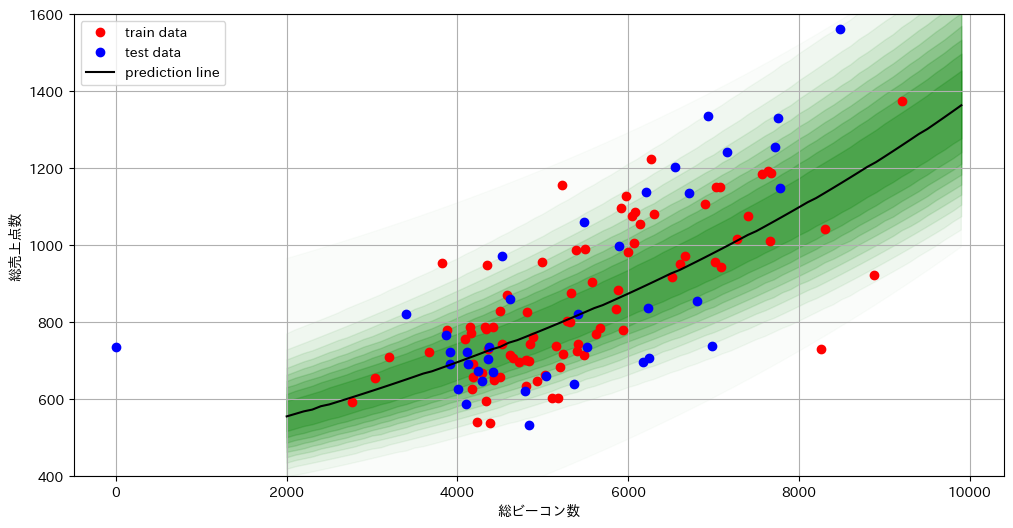

In [10]:
thd_stair  = 10
y_min  = np.min(pred_prob, axis=1)
y_max  = np.max(pred_prob, axis=1)
y_thd  = np.zeros([len(x), thd_stair])
for idx in range(0, len(x)):
    y_thd[idx, :] = np.arange(y_min[idx], y_max[idx], (y_max[idx] - y_min[idx]) / thd_stair)

y_mode = [pred_y[idx, elem] for idx, elem in enumerate(np.argmax(pred_prob, axis=1))]

plt.figure(figsize=(12, 6))

for stair in range(0, thd_stair):
    lower = np.zeros([len(y_mode)])
    upper = np.zeros([len(y_mode)])
    for idx in range(0, len(y_mode)):
        begin = np.where(pred_prob[idx, :] > y_thd[idx, stair])[0][0]
        end   = np.where(pred_prob[idx, :] > y_thd[idx, stair])[0][-1]
        lower[idx] = np.abs(y_mode[idx] - pred_y[idx, begin])
        upper[idx] = np.abs(y_mode[idx] - pred_y[idx, end])

    plt.fill_between(x.reshape(len(x)), y_mode - lower, y_mode + upper, color="green", alpha=(0.2*((stair + 1)/thd_stair)))

plt.plot(X_train, y_train, "o", color="red",   label="train data")
plt.plot(X_test,  y_test,  "o", color="blue",  label="test data")
plt.plot(x,       y_mode,  "-", color="black", label="prediction line")
plt.xlabel("総ビーコン数")
plt.ylabel("総売上点数")
plt.ylim(400, 1600)
plt.grid(True)
plt.legend()